# Chapter 12 - Notes

## Set Up

### Packages

In [2]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [3]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [4]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"

RANDOM_SEED = 42

In [5]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 12.1 Over-dispersed counts

### 12.1.1 Beta-binomial

Let's take a look at the Beta distribution for a few values of the parameters.

There are few different parameterisations floating around.
Both SciPy and PyMC give parameterisations in terms of $\alpha$ and $\beta$.
The book has $\bar{p}$ and $\theta$.
These are $\mu$ (the mean) and $\kappa$ in PyMC.
So we have the following conversions:

\begin{align}
    \alpha & = \bar{p}\theta & \bar{p} & = \frac{\alpha}{\alpha + \beta} & \mu & = \bar{p},\\
    \beta & = (1 - \bar{p})\theta & \theta & = \alpha + \beta & \sigma^2 & = \frac{p(1-p)}{\theta + 1} = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}.\\
\end{align}

In [111]:
def beta_pdf(xval, pbar, theta):
    a = pbar * theta
    b = (1 - pbar) * theta
    return stats.beta.pdf(x_val, a=a, b=b)

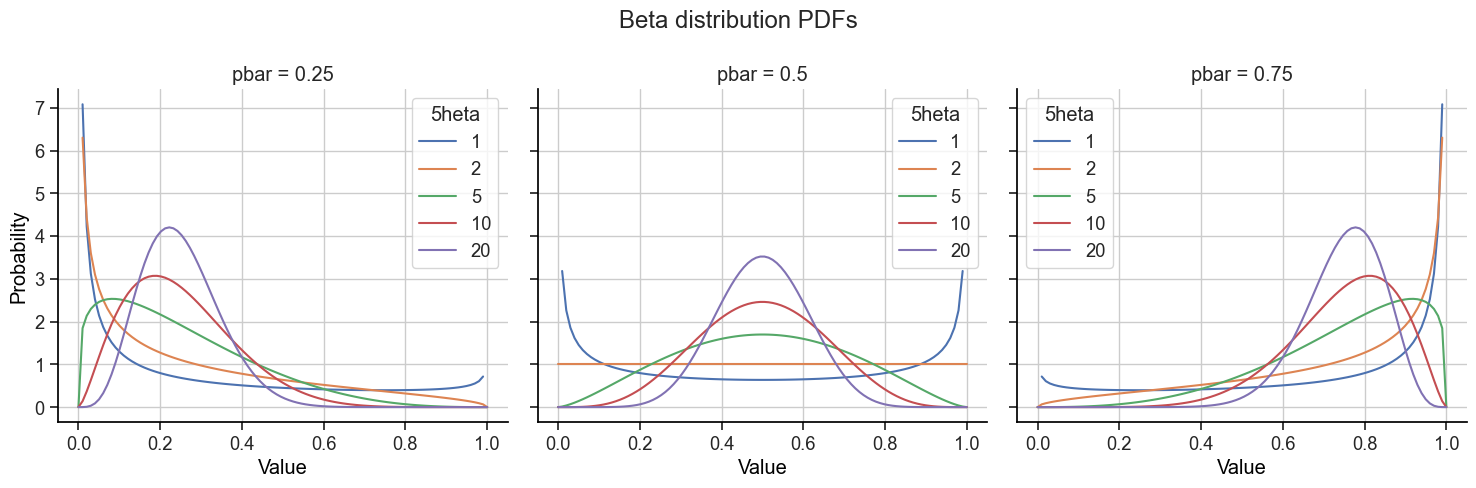

In [114]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))

pbars = np.array([0.25, 0.5, 0.75])
thetas = np.array([1, 2, 5, 10, 20])

x_val = np.linspace(0, 1, 100)
for pbar, ax in zip(pbars, axs):
    for theta in thetas:
        ax.plot(
            x_val,
            beta_pdf(x_val, pbar, theta),
            label=str(theta)
        )
    
    ax.set(
        xlabel="Value",
        title=f"pbar = {pbar}"
    )
    ax.legend(title="5heta")

axs[0].set(ylabel="Probability")

fig.suptitle("Beta distribution PDFs")
fig.tight_layout();

Now let's fit a model using the admissions data.

Load the data.

In [21]:
# load the data
admit = load_data(ADMISSIONS_FILE, delimiter=";")

# cleaning
admit = admit.rename(
    columns={
        "applicant.gender": "gender",
    }
)

# create index variables
admit["gender_idx"], genders = pd.factorize(admit["gender"])

Specify the model.

In [51]:
coords = {
    "obs": admit.index,
    "gender": genders,
    
}
with pm.Model(coords=coords) as m12_1:
    # data
    gender_idx = pm.MutableData("gender_idx", admit.gender_idx, dims="obs")
    applications = pm.MutableData("applications", admit.applications, dims="obs")
    
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="gender")
    phi = pm.Exponential("phi", lam=1)
    
    # derived values
    pbar = pm.Deterministic("pbar", pm.math.invlogit(alpha[gender_idx]), dims="obs")
    theta = pm.Deterministic("theta", phi + 2)
    
    # likelihood
    admissions = pm.BetaBinomial(
        "admissions",
        n=applications,
        alpha=pbar * theta,
        beta=(1 - pbar) * theta,
        observed=admit.admit,
        dims="obs"
    )
    
    # gender contract
    gender_contrast = pm.Deterministic("gender_contrast", alpha[0] - alpha[1])
    
    # inference button
    trace_12_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


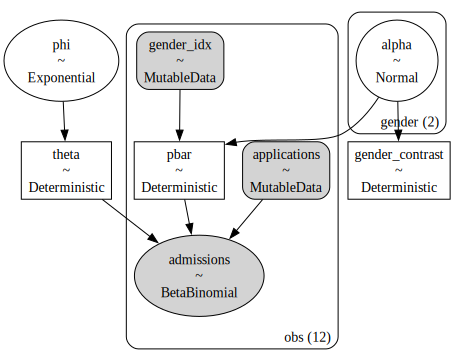

In [52]:
m12_1.to_graphviz()

Inspect the posteriors

In [53]:
az.summary(
    trace_12_1,
    var_names=["alpha", "theta", "gender_contrast"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[male],-0.45,0.42,-1.12,0.19
alpha[female],-0.32,0.42,-1.01,0.32
theta,3.03,0.81,2.00,4.06
gender_contrast,-0.13,0.59,-1.08,0.77


Let's sample some posterior values of $\bar{p}$ and $\theta$ and plot the corresponding Beta distributions.
We also want to plot the MAP.

Start by fetching the MAP.

In [47]:
with m12_1:
    map_ = pm.find_MAP()

Now plot the posterior distributions.

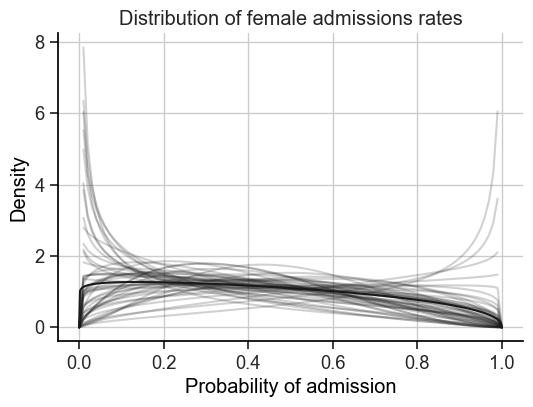

In [116]:
n_lines = 50

fig, ax = plt.subplots(figsize=(6, 4))

x_val = np.linspace(0, 1, 100)

# plot the MAP distribution
alpha_map = map_["alpha"][1]
theta_map = map_["theta"]

x_val = np.linspace(0, 1, 500)
ax.plot(
    x_val,
    beta_pdf(x_val, expit(alpha_map), theta_map),
    color="k"
)

# now plot a selection of distributions
alphas = trace_12_1.posterior.alpha.sel(gender="female", chain=0).isel(draw=slice(n_lines)).values
thetas = trace_12_1.posterior.theta.sel(chain=0).isel(draw=slice(n_lines)).values

pbars = expit(alphas)
x_val = np.linspace(0, 1, 100)
for pbar, theta in zip(pbars, thetas):
    ax.plot(
        x_val,
        beta_pdf(x_val, pbar, theta),
        color="k",
        alpha=0.2,
    )

ax.set(
    xlabel="Probability of admission",
    ylabel="Density",
    title="Distribution of female admissions rates",
);